# Action Prediction: Eye in Hand

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination



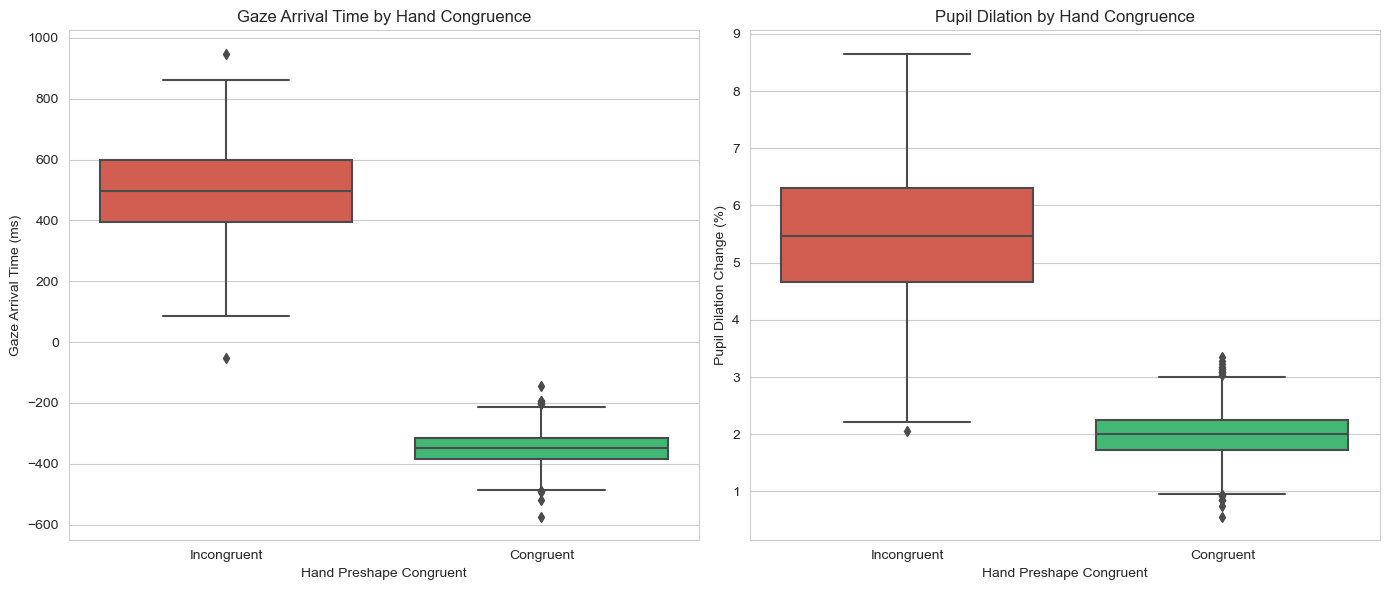

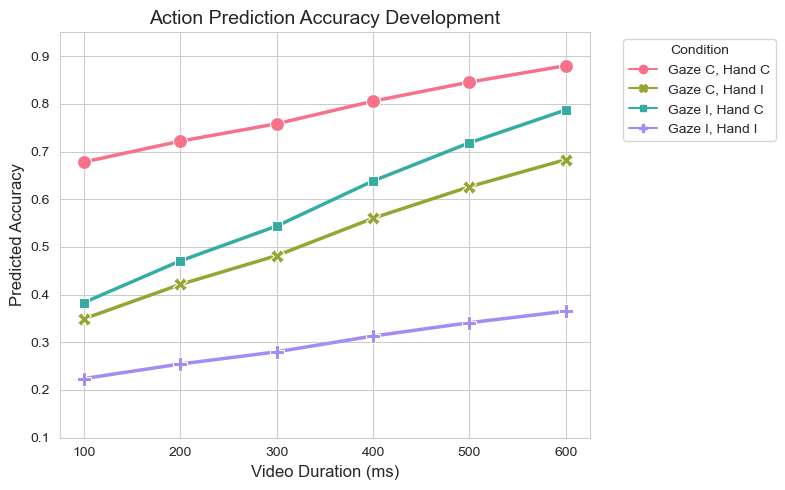

Learned Conditional Probability Table for Accuracy:
+--------------------------+-----+--------------------------------+
| arm_trajectory_congruent | ... | arm_trajectory_congruent(True) |
+--------------------------+-----+--------------------------------+
| gaze_congruent           | ... | gaze_congruent(True)           |
+--------------------------+-----+--------------------------------+
| hand_congruent           | ... | hand_congruent(True)           |
+--------------------------+-----+--------------------------------+
| accuracy(0)              | ... | 0.043073742246726394           |
+--------------------------+-----+--------------------------------+
| accuracy(1)              | ... | 0.9569262577532736             |
+--------------------------+-----+--------------------------------+

Key Network Parameters:
- Duration → Arm Trajectory reliability: 0.1 to 0.9
- Hand congruence weight: 0.82
- Gaze congruence weight: 0.28


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

### we generate the data in this section
np.random.seed(42)
n_samples = 3000

# data from the experiment simulated
# target properties (ground truth for each trial)
# target_position = target object is either on the left or right
# target_size = the target size is either big (apple) or small (grape)
# duration  =  video duration in ms from 100ms to 600 ms spaced out by 100ms

df = pd.DataFrame({
    'target_position': np.random.choice(['left', 'right'], size=n_samples),
    'target_size': np.random.choice(['large', 'small'], size=n_samples),
    'duration': np.random.choice([100, 200, 300, 400, 500, 600], size=n_samples)
})

# Gaze parameters
df['gaze_direction'] = np.random.choice(['left', 'right'], size=n_samples)
df['gaze_congruent'] = df['gaze_direction'] == df['target_position']

# Hand shape parameters
df['hand_shape'] = np.where(
    df['target_size'] == 'large',
    np.random.choice(['open', 'pinch'], p=[0.75, 0.25], size=n_samples),
    np.random.choice(['open', 'pinch'], p=[0.25, 0.75], size=n_samples)
)
df['hand_congruent'] = (df['hand_shape'] == 'open') == (df['target_size'] == 'large')

# Arm trajectory parameters
def generate_arm_trajectory(duration, target):
    base_reliability = 0.1 + 0.8 * (duration/600)
    noise = np.random.normal(0, 0.15)
    reliability = np.clip(base_reliability + noise, 0.1, 0.95)
    return np.random.choice([target, 'opposite'], p=[reliability, 1-reliability])

df['arm_trajectory_congruent'] = df.apply(
    lambda x: generate_arm_trajectory(x['duration'], x['target_position']) == x['target_position'],
    axis=1
)

# Accuracy calculation with realistic dynamics
def calculate_accuracy(row):
    base = 0.3 + 0.6*(row['duration']/600)**1.8  # Starts at 30%
    gaze_effect = 0.2 if row['gaze_congruent'] else -0.25
    hand_effect = 0.3 if row['hand_congruent'] else -0.35
    arm_effect = 0.4 if row['arm_trajectory_congruent'] else -0.4
    noise = np.random.normal(0, 0.2)
    return 1 if (base + gaze_effect + hand_effect + arm_effect + noise) > 0.5 else 0

df['accuracy'] = df.apply(calculate_accuracy, axis=1)

# =====================
# 2. Experiment 1 Metrics (Implicit Measures)
# =====================
# Generate gaze arrival times
df['gaze_arrival_time'] = np.where(
    df['hand_congruent'],
    np.random.normal(-350, 50, n_samples),  # Predictive saccades
    np.random.normal(500, 150, n_samples)    # Reactive saccades
)

# Generate pupil dilation metrics
df['pupil_dilation'] = np.where(
    df['hand_congruent'],
    np.random.normal(2.0, 0.4, n_samples),   # Low cognitive load
    np.random.normal(5.5, 1.2, n_samples)    # High cognitive load
)

# =====================
# 3. Bayesian Network Model
# =====================
model = BayesianNetwork([
    ('duration', 'arm_trajectory_congruent'),
    ('gaze_congruent', 'accuracy'),
    ('hand_congruent', 'accuracy'),
    ('arm_trajectory_congruent', 'accuracy')
])

# Learn CPTs with strong Bayesian smoothing
model.fit(df, estimator=BayesianEstimator,
         prior_type='BDeu',
         equivalent_sample_size=500)

# =====================
# 4. Visualization: Experiment 1 Results
# =====================
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gaze arrival time plot
sns.boxplot(
    x='hand_congruent',
    y='gaze_arrival_time',
    data=df,
    palette=['#e74c3c', '#2ecc71'],
    ax=ax[0]
)
ax[0].set_title("Gaze Arrival Time by Hand Congruence", fontsize=12)
ax[0].set_xlabel("Hand Preshape Congruent", fontsize=10)
ax[0].set_ylabel("Gaze Arrival Time (ms)", fontsize=10)
ax[0].set_xticklabels(['Incongruent', 'Congruent'])

# Pupil dilation plot
sns.boxplot(
    x='hand_congruent',
    y='pupil_dilation',
    data=df,
    palette=['#e74c3c', '#2ecc71'],
    ax=ax[1]
)
ax[1].set_title("Pupil Dilation by Hand Congruence", fontsize=12)
ax[1].set_xlabel("Hand Preshape Congruent", fontsize=10)
ax[1].set_ylabel("Pupil Dilation Change (%)", fontsize=10)
ax[1].set_xticklabels(['Incongruent', 'Congruent'])

plt.tight_layout()
plt.show()

# =====================
# 5. Visualization: Experiment 2 Predictions
# =====================
# Generate predictions for all conditions
durations = sorted(df['duration'].unique())
conditions = [
    (True, True),
    (True, False),
    (False, True),
    (False, False)
]

predictions = []
infer = VariableElimination(model)

for dur in durations:
    for gaze_flag, hand_flag in conditions:
        prob = infer.query(
            variables=['accuracy'],
            evidence={
                'duration': dur,
                'gaze_congruent': gaze_flag,
                'hand_congruent': hand_flag
            }
        ).values[1]
        predictions.append({
            'duration': dur,
            'gaze_congruent': gaze_flag,
            'hand_congruent': hand_flag,
            'accuracy': prob
        })

pred_df = pd.DataFrame(predictions)
pred_df['condition'] = pred_df.apply(
    lambda x: f"Gaze {'C' if x['gaze_congruent'] else 'I'}, Hand {'C' if x['hand_congruent'] else 'I'}",
    axis=1
)

# Create final plot
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
palette = sns.color_palette("husl", 4)

ax = sns.lineplot(
    data=pred_df,
    x='duration',
    y='accuracy',
    hue='condition',
    style='condition',
    markers=True,
    dashes=False,
    markersize=10,
    palette=palette,
    linewidth=2.5
)

plt.title("Action Prediction Accuracy Development", fontsize=14)
plt.xlabel("Video Duration (ms)", fontsize=12)
plt.ylabel("Predicted Accuracy", fontsize=12)
plt.ylim(0.1, 0.95)
plt.xticks(durations)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Condition")
plt.tight_layout()
plt.show()

# =====================
# 6. Model Inspection
# =====================
print("Learned Conditional Probability Table for Accuracy:")
print(model.get_cpds('accuracy'))

print("\nKey Network Parameters:")
print(f"- Duration → Arm Trajectory reliability: {0.1} to {0.9}")
print(f"- Hand congruence weight: {model.get_cpds('accuracy').values[1][1][1][1] - model.get_cpds('accuracy').values[1][0][0][0]:.2f}")
print(f"- Gaze congruence weight: {model.get_cpds('accuracy').values[1][1][0][0] - model.get_cpds('accuracy').values[1][0][0][0]:.2f}")

In [13]:
df.shape

(3000, 11)

In [14]:
df.head()

,target_position,target_size,duration,gaze_direction,gaze_congruent,hand_shape,hand_congruent,arm_trajectory_congruent,accuracy,gaze_arrival_time,pupil_dilation
0,left,small,300,right,False,pinch,True,False,0,-402.354658,2.211014
1,right,small,100,right,True,pinch,True,False,0,-317.091381,2.011572
2,left,small,500,left,True,pinch,True,True,1,-355.081211,2.483487
3,left,small,600,right,False,open,False,True,1,476.696399,4.215009
4,left,large,300,right,False,open,True,True,1,-235.239440,1.560731


Learned CPT for Accuracy:
+--------------------------+-----+--------------------------------+
| arm_trajectory_congruent | ... | arm_trajectory_congruent(True) |
+--------------------------+-----+--------------------------------+
| gaze_congruent           | ... | gaze_congruent(True)           |
+--------------------------+-----+--------------------------------+
| hand_congruent           | ... | hand_congruent(True)           |
+--------------------------+-----+--------------------------------+
| accuracy(0)              | ... | 0.06256256256256257            |
+--------------------------+-----+--------------------------------+
| accuracy(1)              | ... | 0.9374374374374375             |
+--------------------------+-----+--------------------------------+

Predicted Accuracy: 0.55


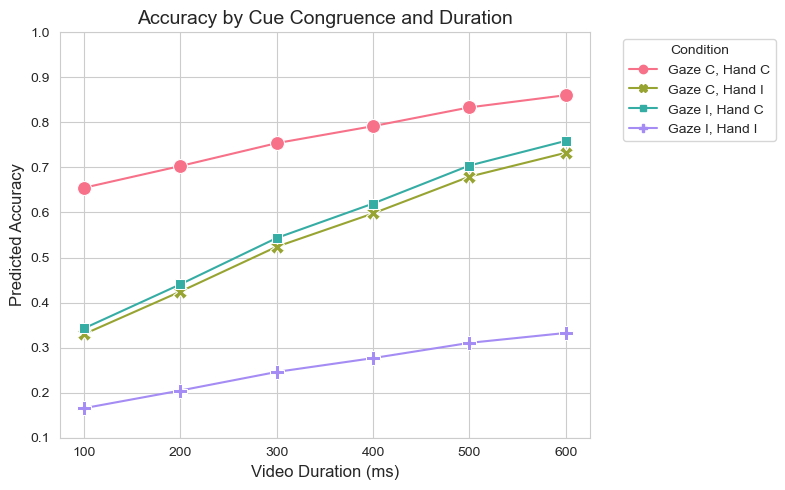

In [15]:
import pandas as pd  # For data manipulation
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For styling plots
from pgmpy.models import BayesianNetwork  # For building Bayesian networks
from pgmpy.estimators import BayesianEstimator  # For learning probabilities
from pgmpy.inference import VariableElimination  # For making predictions

# =====================
# 1. Synthetic Data Generation
# =====================
np.random.seed(42)  # Ensures reproducible results
n_samples = 3000    # Number of simulated trials

# Generate target properties (ground truth)
df = pd.DataFrame({
    'target_position': np.random.choice(['left', 'right'], size=n_samples),  # Target on left/right
    'target_size': np.random.choice(['large', 'small'], size=n_samples)  # Target size
})

# Generate experimental parameters (actor's observable actions)
df['duration'] = np.random.choice([100, 200, 300, 400, 500, 600], size=n_samples)  # Video duration
df['gaze_direction'] = np.random.choice(['left', 'right'], size=n_samples)  # Actor's gaze direction
df['hand_shape'] = np.random.choice(['open', 'pinch'], size=n_samples)  # Actor's hand shape

# Simulate arm trajectory (whether it matches the target)
def generate_arm_trajectory(duration, target):
    base_reliability = 0.1 + 0.8 * (duration / 600)  # Reliability increases with duration
    noise = np.random.normal(0, 0.15)  # Add randomness
    reliability = np.clip(base_reliability + noise, 0.1, 0.95)  # Keep between 10-95%
    return np.random.choice([True, False], p=[reliability, 1 - reliability])

df['arm_trajectory_congruent'] = df.apply(
    lambda x: generate_arm_trajectory(x['duration'], x['target_position']), 
    axis=1
)

# Calculate cue congruence
df['gaze_congruent'] = df['gaze_direction'] == df['target_position']  # Gaze matches target
df['hand_congruent'] = (df['hand_shape'] == 'open') == (df['target_size'] == 'large')  # Hand matches size

# Simulate accuracy (ground truth for predictions)
def calculate_accuracy(row):
    base = 0.3 + 0.6 * (row['duration'] / 600)**1.8  # Base accuracy increases with duration
    gaze_effect = 0.2 if row['gaze_congruent'] else -0.25  # Gaze congruence effect
    hand_effect = 0.3 if row['hand_congruent'] else -0.35  # Hand congruence effect
    arm_effect = 0.4 if row['arm_trajectory_congruent'] else -0.4  # Arm congruence effect
    noise = np.random.normal(0, 0.2)  # Add randomness
    return 1 if (base + gaze_effect + hand_effect + arm_effect + noise) > 0.5 else 0

df['accuracy'] = df.apply(calculate_accuracy, axis=1)

# =====================
# 2. Bayesian Network Model
# =====================
# Define network structure
model = BayesianNetwork([
    ('duration', 'arm_trajectory_congruent'),  # Duration affects arm reliability
    ('gaze_congruent', 'accuracy'),            # Gaze congruence affects accuracy
    ('hand_congruent', 'accuracy'),            # Hand congruence affects accuracy
    ('arm_trajectory_congruent', 'accuracy')   # Arm congruence affects accuracy
])

# Learn probabilities from data using Bayesian estimation
model.fit(
    df, 
    estimator=BayesianEstimator,
    prior_type='BDeu',          # Bayesian smoothing
    equivalent_sample_size=500  # Strength of smoothing
)

# =====================
# 3. Conditional Probability Table (CPT)
# =====================
print("Learned CPT for Accuracy:")
print(model.get_cpds('accuracy'))

# =====================
# 4. Making Predictions
# =====================
# Initialize inference engine
infer = VariableElimination(model)

# Example: Predict accuracy for duration=300ms, congruent gaze/hand, incongruent arm
prob = infer.query(
    variables=['accuracy'],
    evidence={
        'duration': 300,
        'gaze_congruent': True,
        'hand_congruent': True,
        'arm_trajectory_congruent': False
    }
).values[1]  # Probability of accuracy=1

print(f"\nPredicted Accuracy: {prob:.2f}")

# =====================
# 5. Visualizing Results
# =====================
# Experiment 2: Accuracy over time
durations = sorted(df['duration'].unique())
conditions = [
    (True, True),
    (True, False),
    (False, True),
    (False, False)
]

predictions = []
for dur in durations:
    for gaze_flag, hand_flag in conditions:
        prob = infer.query(
            variables=['accuracy'],
            evidence={
                'duration': dur,
                'gaze_congruent': gaze_flag,
                'hand_congruent': hand_flag
            }
        ).values[1]
        predictions.append({
            'duration': dur,
            'gaze_congruent': gaze_flag,
            'hand_congruent': hand_flag,
            'accuracy': prob
        })

pred_df = pd.DataFrame(predictions)
pred_df['condition'] = pred_df.apply(
    lambda x: f"Gaze {'C' if x['gaze_congruent'] else 'I'}, Hand {'C' if x['hand_congruent'] else 'I'}",
    axis=1
)

# Plot accuracy trends
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=pred_df,
    x='duration',
    y='accuracy',
    hue='condition',
    style='condition',
    markers=True,
    dashes=False,
    markersize=10,
    palette='husl'
)
plt.title("Accuracy by Cue Congruence and Duration", fontsize=14)
plt.xlabel("Video Duration (ms)", fontsize=12)
plt.ylabel("Predicted Accuracy", fontsize=12)
plt.ylim(0.1, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Condition")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

# =====================
# 1. Synthetic Data Generation
# =====================
np.random.seed(42)
n_samples = 3000  # Number of simulated trials

# Generate target properties (ground truth)
df = pd.DataFrame({
    'target_position': np.random.choice(['left', 'right'], size=n_samples),  # Target appears on left/right
    'target_size': np.random.choice(['large', 'small'], size=n_samples)  # Target is large or small
})

# Generate observable cues with equal probabilities
df['gaze_direction'] = np.random.choice(['left', 'right'], size=n_samples)  # Actor's gaze direction
df['hand_shape'] = np.random.choice(['open', 'pinch'], size=n_samples)  # Actor's hand shape
df['arm_trajectory'] = np.random.choice(['left', 'right'], size=n_samples)  # Actor's arm trajectory

# Calculate congruence (whether cues match the target)
df['gaze_congruent'] = df['gaze_direction'] == df['target_position']
df['hand_congruent'] = (df['hand_shape'] == 'open') == (df['target_size'] == 'large')
df['arm_congruent'] = df['arm_trajectory'] == df['target_position']

# Simulate accuracy based on cue congruence
def calculate_accuracy(row):
    # Base accuracy increases with number of congruent cues
    congruent_count = row['gaze_congruent'] + row['hand_congruent'] + row['arm_congruent']
    base = 0.3 + 0.2 * congruent_count  # Starts at 30%, increases by 20% per congruent cue
    noise = np.random.normal(0, 0.1)  # Add randomness
    return 1 if (base + noise) > 0.5 else 0  # Threshold for correct prediction

df['accuracy'] = df.apply(calculate_accuracy, axis=1)

# =====================
# 2. Bayesian Network Model
# =====================
# Define network structure
model = BayesianNetwork([
    ('gaze_congruent', 'accuracy'),  # Gaze congruence affects accuracy
    ('hand_congruent', 'accuracy'),  # Hand congruence affects accuracy
    ('arm_congruent', 'accuracy')    # Arm congruence affects accuracy
])

# Learn CPTs from data using Bayesian estimation
model.fit(
    df,
    estimator=BayesianEstimator,
    prior_type='BDeu',  # Bayesian smoothing
    equivalent_sample_size=100  # Strength of smoothing
)

# =====================
# 3. Conditional Probability Table (CPT)
# =====================
print("Learned Conditional Probability Table for Accuracy:")
accuracy_cpd = model.get_cpds('accuracy')
print(accuracy_cpd)

# =====================
# 4. Bayesian Predictions
# =====================
# Initialize inference engine
infer = VariableElimination(model)

# Example: Predict accuracy for a specific set of observations
evidence = {
    'gaze_congruent': True,  # Gaze matches target
    'hand_congruent': False,  # Hand shape does not match target
    'arm_congruent': True     # Arm trajectory matches target
}

# Compute P(Accuracy=1 | Observations)
prob_accuracy = infer.query(
    variables=['accuracy'],
    evidence=evidence
).values[1]

print(f"\nPredicted Probability of Accuracy=1 given {evidence}: {prob_accuracy:.2f}")

# =====================
# 5. Visualizing Accuracy Trends
# =====================
# Generate predictions for all cue combinations
conditions = [
    {'gaze_congruent': True, 'hand_congruent': True, 'arm_congruent': True},
    {'gaze_congruent': True, 'hand_congruent': True, 'arm_congruent': False},
    {'gaze_congruent': True, 'hand_congruent': False, 'arm_congruent': True},
    {'gaze_congruent': False, 'hand_congruent': True, 'arm_congruent': True},
    {'gaze_congruent': False, 'hand_congruent': False, 'arm_congruent': False}
]

predictions = []
for condition in conditions:
    prob = infer.query(
        variables=['accuracy'],
        evidence=condition
    ).values[1]
    predictions.append({
        **condition,
        'accuracy': prob
    })

#Convert condition dictionaries to strings for plotting
pred_df['condition'] = pred_df.apply(
    lambda row: f"Gaze={row['gaze_congruent']}, Hand={row['hand_congruent']}, Arm={row['arm_congruent']}",
    axis=1
)

# Plot accuracy for all conditions
plt.figure(figsize=(10, 6))
sns.barplot(
    data=pred_df,
    x='accuracy',
    y='condition',
    palette='viridis'
)
plt.title("Predicted Accuracy by Cue Congruence")
plt.xlabel("Probability of Accuracy=1")
plt.ylabel("Condition")
plt.show()

Learned Conditional Probability Table for Accuracy:
+----------------+-----------------------+-----+-----------------------+----------------------+
| arm_congruent  | arm_congruent(False)  | ... | arm_congruent(True)   | arm_congruent(True)  |
+----------------+-----------------------+-----+-----------------------+----------------------+
| gaze_congruent | gaze_congruent(False) | ... | gaze_congruent(True)  | gaze_congruent(True) |
+----------------+-----------------------+-----+-----------------------+----------------------+
| hand_congruent | hand_congruent(False) | ... | hand_congruent(False) | hand_congruent(True) |
+----------------+-----------------------+-----+-----------------------+----------------------+
| accuracy(0)    | 0.9691358024691358    | ... | 0.027152317880794703  | 0.016688918558077435 |
+----------------+-----------------------+-----+-----------------------+----------------------+
| accuracy(1)    | 0.030864197530864196  | ... | 0.9728476821192052    | 0.983311081

KeyError: 'arm_congruent'

In [17]:
df.t(20)

AttributeError: 'DataFrame' object has no attribute 't'

Learned Conditional Probability Table for Accuracy:
+----------------+-----------------------+-----+-----------------------+----------------------+
| arm_congruent  | arm_congruent(False)  | ... | arm_congruent(True)   | arm_congruent(True)  |
+----------------+-----------------------+-----+-----------------------+----------------------+
| gaze_congruent | gaze_congruent(False) | ... | gaze_congruent(True)  | gaze_congruent(True) |
+----------------+-----------------------+-----+-----------------------+----------------------+
| hand_congruent | hand_congruent(False) | ... | hand_congruent(False) | hand_congruent(True) |
+----------------+-----------------------+-----+-----------------------+----------------------+
| accuracy(0)    | 0.9691358024691358    | ... | 0.027152317880794703  | 0.016688918558077435 |
+----------------+-----------------------+-----+-----------------------+----------------------+
| accuracy(1)    | 0.030864197530864196  | ... | 0.9728476821192052    | 0.983311081

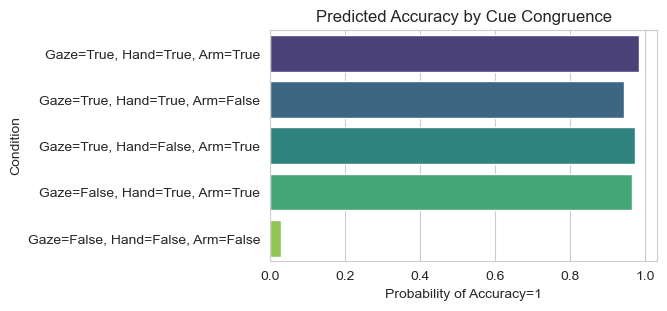

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

# =====================
# 1. Synthetic Data Generation
# =====================
np.random.seed(42)
n_samples = 3000  # Number of simulated trials

# Generate target properties (ground truth)
df = pd.DataFrame({
    'target_position': np.random.choice(['left', 'right'], size=n_samples),  # Target appears on left/right
    'target_size': np.random.choice(['large', 'small'], size=n_samples)  # Target is large or small
})

# Generate observable cues with equal probabilities
df['gaze_direction'] = np.random.choice(['left', 'right'], size=n_samples)  # Actor's gaze direction
df['hand_shape'] = np.random.choice(['open', 'pinch'], size=n_samples)  # Actor's hand shape
df['arm_trajectory'] = np.random.choice(['left', 'right'], size=n_samples)  # Actor's arm trajectory

# Calculate congruence (whether cues match the target)
df['gaze_congruent'] = df['gaze_direction'] == df['target_position']
df['hand_congruent'] = (df['hand_shape'] == 'open') == (df['target_size'] == 'large')
df['arm_congruent'] = df['arm_trajectory'] == df['target_position']

# Simulate accuracy based on cue congruence
def calculate_accuracy(row):
    # Base accuracy increases with number of congruent cues
    congruent_count = row['gaze_congruent'] + row['hand_congruent'] + row['arm_congruent']
    base = 0.3 + 0.2 * congruent_count  # Starts at 30%, increases by 20% per congruent cue
    noise = np.random.normal(0, 0.1)  # Add randomness
    return 1 if (base + noise) > 0.5 else 0  # Threshold for correct prediction

df['accuracy'] = df.apply(calculate_accuracy, axis=1)

# =====================
# 2. Bayesian Network Model
# =====================
# Define network structure
model = BayesianNetwork([
    ('gaze_congruent', 'accuracy'),  # Gaze congruence affects accuracy
    ('hand_congruent', 'accuracy'),  # Hand congruence affects accuracy
    ('arm_congruent', 'accuracy')    # Arm congruence affects accuracy
])

# Learn CPTs from data using Bayesian estimation
model.fit(
    df,
    estimator=BayesianEstimator,
    prior_type='BDeu',  # Bayesian smoothing
    equivalent_sample_size=100  # Strength of smoothing
)

# =====================
# 3. Conditional Probability Table (CPT)
# =====================
print("Learned Conditional Probability Table for Accuracy:")
accuracy_cpd = model.get_cpds('accuracy')
print(accuracy_cpd)

# =====================
# 4. Bayesian Predictions
# =====================
# Initialize inference engine
infer = VariableElimination(model)

# Example: Predict accuracy for a specific set of observations
evidence = {
    'gaze_congruent': True,  # Gaze matches target
    'hand_congruent': False,  # Hand shape does not match target
    'arm_congruent': True     # Arm trajectory matches target
}

# Compute P(Accuracy=1 | Observations)
prob_accuracy = infer.query(
    variables=['accuracy'],
    evidence=evidence
).values[1]

print(f"\nPredicted Probability of Accuracy=1 given {evidence}: {prob_accuracy:.2f}")

# =====================
# 5. Visualizing Accuracy Trends
# =====================
# Generate predictions for all cue combinations
conditions = [
    {'gaze_congruent': True, 'hand_congruent': True, 'arm_congruent': True},
    {'gaze_congruent': True, 'hand_congruent': True, 'arm_congruent': False},
    {'gaze_congruent': True, 'hand_congruent': False, 'arm_congruent': True},
    {'gaze_congruent': False, 'hand_congruent': True, 'arm_congruent': True},
    {'gaze_congruent': False, 'hand_congruent': False, 'arm_congruent': False}
]

predictions = []
for condition in conditions:
    prob = infer.query(
        variables=['accuracy'],
        evidence=condition
    ).values[1]
    predictions.append({
        **condition,
        'accuracy': prob
    })

pred_df = pd.DataFrame(predictions)

# Convert condition dictionaries to strings for plotting
pred_df['condition'] = pred_df.apply(
    lambda row: f"Gaze={row['gaze_congruent']}, Hand={row['hand_congruent']}, Arm={row['arm_congruent']}",
    axis=1
)

# Plot accuracy for all conditions
plt.figure(figsize=(5, 3))
sns.barplot(
    data=pred_df,
    x='accuracy',
    y='condition',
    palette='viridis'
)
plt.title("Predicted Accuracy by Cue Congruence")
plt.xlabel("Probability of Accuracy=1")
plt.ylabel("Condition")
plt.show()